# Проект: Система поиска подходящих товаров на основе дообученной CLIP модели


## Постановка задачи

Нужно реализовать такую систему: пользователь описывает вещь словами, система находит и показывает наиболее близкие позиции из базы. Компания выходит на международный рынок, поэтому система будет работать на английском языке.

Нужно:
- дообучить модель CLIP на датасете товаров из магазинов одежды,
- реализовать систему поиска изображений товаров по текстовым запросам.

## Критерии успеха

- Целевые значения **среднего CLIP** score должны быть **выше 30**.
- Ожидаемый результат: реализована поисковая система, способная принимать текстовые запросы и возвращать наиболее релевантные изображения из датасета. Система должна работать эффективно, то есть не пересчитывать каждый раз векторные представления картинок.

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных
[Ссылка](https://www.kaggle.com/datasets/nirmalsankalana/fashion-product-text-images-dataset) на датасет.

Датасет содержит картинки и таблицу `data.csv`.

В этой таблице такие поля: 
- `image` — название файла изображения в папке с изображениями.
- `description` — описание элемента одежды, изображённого на картинке.
- `display name` — название элемента на картинке.
- `category` — категория элемента одежды.

В проекте вам понадобятся только первые два столбца: `image` — для визуальных данных, `description` — для текстовых.

## Инициализация

In [ ]:
JUST_DEBUG_ON_CPU = False # 👷🚧🚧🚧🚧🚧 переключить в False при итоговом обучении и замере

RANDOM_STATE = 42

DATA_CSV_PATH = "archive/data.csv"
IMAGES_PATH = "archive/data/"

#MODEL_NAME = "openai/clip-vit-base-patch32"
MODEL_NAME = "/home/user/clipmodel"

BATCH_SIZE = 32
NUM_EPOCHS = 4 if not JUST_DEBUG_ON_CPU else 1
CHECKPOINT_DIR = "clip_checkpoints"

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
import gc
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from tqdm import tqdm

/home/user/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Fine-tuning CLIP

## Загрузка и исследовательский анализ данных


In [3]:
df = pd.read_csv(DATA_CSV_PATH).drop(columns=['display name', 'category'])

In [4]:
if JUST_DEBUG_ON_CPU:
    df = df[:500]

In [5]:
pd.options.display.max_colwidth = 1000

In [6]:
df.head()

,image,description
0,3238.jpg,"Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only"
1,43044.jpg,"Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit"
2,54018.jpg,"Teal handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back"
3,8141.jpg,"Perfectly stylish, this fastrack analog wrist watch is a great buy for those who enjoy performance and style. With excellent touches and comfort, this watch makes for an excellent daily wear. Case diameter : 30 mm Case thickness : 5 mm Dial shape : Square Plastic case with a fixed bezel for added durability, style and comfort Leather strap with stitch detailing, brand name printed on the inner part and a tang clasp Silver dial in a radiating pattern with minute marking in pink from 6 o& rsquo clock to 12 o& rsquo clock position, brand name at 3 o& rsquo clock position and brand logo at 12 o& rsquo clock position Quartz movement of time display with carved out hour and minute hands Screw to reset time Solid case back made of stainless steel for enhanced durability Water resistance at 30 meters, allowing you to use it even when swimming"
4,22245.jpg,"These id mid-top chukka shoes add a fresh spin on a classic style with its wide midsole. The humble sneaker reached a new high with this casual shoe, with its contrasting textures and subtle colour map. Wear this with a crisp shirt, a half zippered sweater and a jacket or blazer on top to achieve the perfect layered look. Pair this with your favourite jeans or chinos. Upper Low top suede upper with synthetic overlay on the heel collar Perforations in the midfoot region for ventilation Central lace ups Padded tongue and collar Mesh lining Contrast stitch detailing Midsole Thick EVA midsole Outsole Rubber outsole with a stacked heel and grooves Shoe care Wipe with a dry cloth to remove dust"


Сразу отделим тестовую выборку, чтобы её не касалась предобработка и очистка.

In [7]:
df_train, df_val = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39996 entries, 0 to 39995
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        39996 non-null  object
 1   description  39743 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


Есть пустые поля с описаниями. Такие образцы нам не нужны - удалим их:

In [10]:
df_train = df_train.dropna()

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39743 entries, 0 to 39995
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        39743 non-null  object
 1   description  39743 non-null  object
dtypes: object(2)
memory usage: 931.5+ KB


Изучим дубликататы датафейрма:

In [12]:
df_train['image'].duplicated().sum()

np.int64(0)

In [13]:
df_train['description'].duplicated().sum()

np.int64(4549)

In [14]:
df_train['description'].value_counts()

description
-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    839
Style Note                                                                                                                                                                                                                                                                                                                                                         

Дубликаты есть, в т. ч. без значимых описаний. Удалим такие:

In [15]:
english_pattern = r'[a-zA-Z]'
mask = ~df_train['description'].str.contains(english_pattern, na=False)
df_train[mask]['description'].value_counts()

description
-       839
2008      1
.         1
          1
          1
Name: count, dtype: int64

In [16]:
df_train = df_train[~mask]

In [17]:
df_train['description'].value_counts()

description
Style Note                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             109
Chip-resistant and prevents yellowing of nails Fast drying and long wearing Simple one stroke application                                                                                                                                                                                                                                                                                                                                                                        

Посмотрим на некоторые группы картинок

In [18]:
def show_images (df_arg):
    for _, row in df_arg.iterrows():
        image_path = os.path.join (IMAGES_PATH, row['image'])
    
        image = Image.open(image_path)
        
        print (f"⬇------------------- изображение {row['image']} -------------------⬇")
        wrapped_description = textwrap.fill(row['description'], width=80)
        print (wrapped_description)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

⬇------------------- изображение 44985.jpg -------------------⬇
Style Note


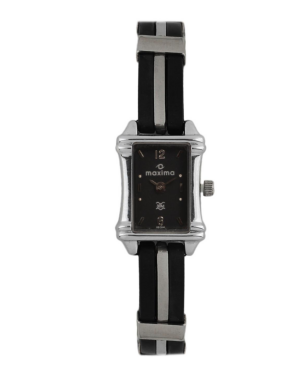

⬇------------------- изображение 45039.jpg -------------------⬇
Style Note


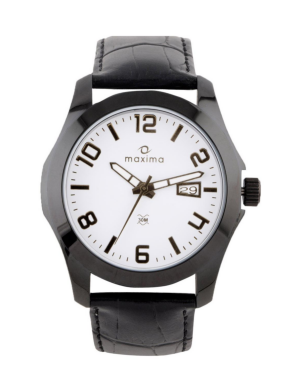

⬇------------------- изображение 52384.jpg -------------------⬇
Style Note


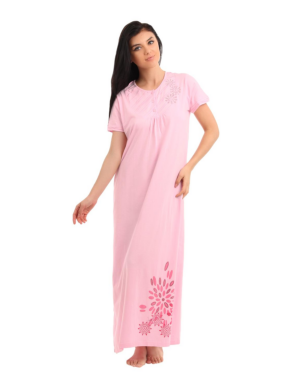

In [19]:
show_images (df_train [df_train['description'] == 'Style Note'][:3])

-- такие дубликаты удалим, т. к. описание бессмысленное, а картинки противоречивые.

In [20]:
df_train = df_train [df_train['description'] != 'Style Note']

⬇------------------- изображение 55940.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


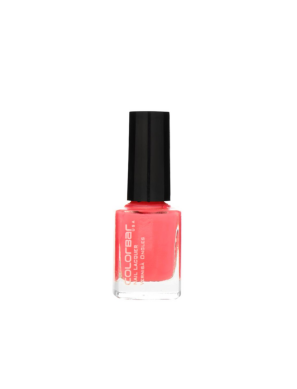

⬇------------------- изображение 55888.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


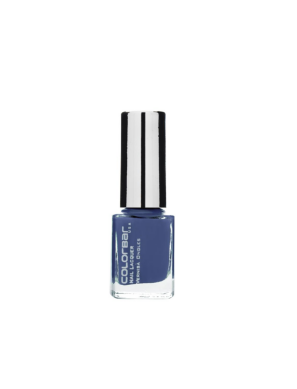

⬇------------------- изображение 55928.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


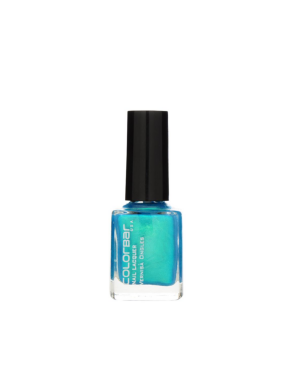

In [21]:
show_images (df_train [df_train['description'] == 'Chip-resistant and prevents yellowing of'
                 ' nails Fast drying and long wearing Simple one stroke application'][:3])

-- такие дубликаты оставим.

Посмотрим разрешения картинок:

In [22]:
def get_resolution (row):
    image_path = os.path.join (IMAGES_PATH, row['image'])
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден по пути {image_path}")
    except Exception as e:
        print(f"Произошла ошибка при обработке изображения: {e}")    


df_train [['width', 'height']] = df_train.apply(get_resolution, axis=1, result_type='expand')

In [23]:
df_train['width'].value_counts()

width
1080    38791
Name: count, dtype: int64

In [24]:
df_train['height'].value_counts()

height
1440    38791
Name: count, dtype: int64

Все изображения имеют разрешение  1080х1440

Посмотрим на несколько случайных изображений и текстов, оценим их соответствие:

In [25]:
pd.options.display.max_colwidth = 10

⬇------------------- изображение 4433.jpg -------------------⬇
Composition Wide blue and white striped polo t-shirt made of 100% cotton, with
wrangler logo stitched on left chest Fitting Comfort Wash care   Light machine
wash  Do not scrub  Do not bleach  Warm iron on reverse  Do not dry clean  Dry
flat/ reverse   Created for casual and semi-formal occasions, this white and
blue striped polo neck wrangler t-shirt gives you a corporate-yet-casual look.
Pair this front buttoned neck cotton tee with chinos and leather or suede shoes
on a casual day at work or with denims and sneakers when chilling out with
friends. Model statistics The model wears size M in t-shirts Height-6',
Shoulders-18"


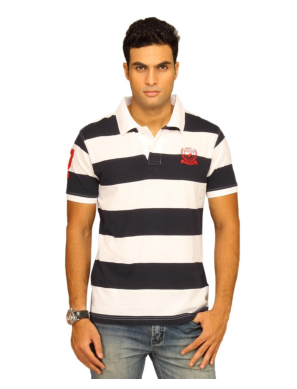

⬇------------------- изображение 5040.jpg -------------------⬇
Enjoy summer in these sleek flip flops from fila. The insole is soft while the
foamy phylon midsole makes the footwear lightweight and cushioned. The wide
straps ensure a snug Fit and the twill tape toe separators give added comfort.
The TPR outsole with 3-D branding enhances grip and stability. Upper   Lightly
padded synthetic straps stitched to the midsole  Comfortable twill tape toe
separators  Embroidery branding on the straps   Midsole   Printed cushioned
footbed for added comfort  Graphiti on the footbed for style  Visible phylon
midsole   Outsole   TPR outsole with 3-D branding for extra grip   shoe care Do
not machine wash Rub with soft, clean cloth to remove dust and dirt


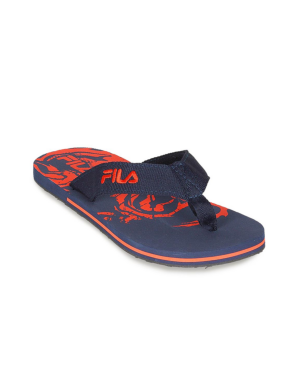

⬇------------------- изображение 52759.jpg -------------------⬇
Style Note A classic carryall is an essential that no woman can do without.
fiorelli tries to address this need with a minimalistic and elegant handbag that
effortlessly slots into your daily wardrobe. Crafted from premium leather, this
piece is specially designed and created with the highest quality standards,
ensuring that it will last for several years to come. Product Details Chocolate
brown bag with metal brand badge on the front Three zippered compartments with
one zippered pocket(has a brand patch), a slip pocket and a mobile slot in the
centre compartment Tabs with rivet detailing at the sides Paneled back and two
short handles for carrying ease Guarantee : 1yr Material and Care Leather Wipe
with clean, dry cloth to remove dirt Size Height: 24 cm Width: 33 cm Depth: 14
cm


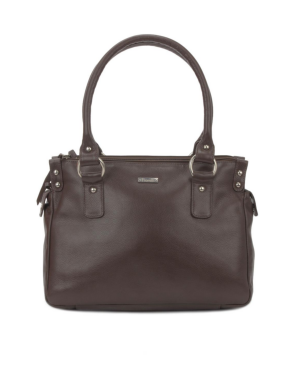

⬇------------------- изображение 24362.jpg -------------------⬇
Composition Brown printed kurta made of 100% cotton, has a mandarin collar with
a split neckline, ruffles on the shoulder and chest, three-quarter sleeves and a
vented hem Fit Regular Wash care Wash dark colours separately Do not bleach Dry
inside out in shade Warm iron The inspiration for this kurta from folklore for
women is the retro-esque fusion of the uniquely ethnic with smart workwear. The
label combines the quirky street style of India's biggest metros with classic
silhouettes. This piece epitomizes how fashion, vintage styling and comfort
unite to create the perfect Indian tunic. Those interested in colour blocking
can wear this with bright contrasting capris or pants. Others who want to keep
their look classic and chic can pair this with tonal leggings, and embellished
slippers. Model statistics The product is a size M on a model of height 5'8" and
chest 33"


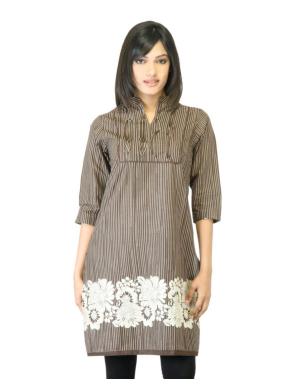

⬇------------------- изображение 59069.jpg -------------------⬇
White brassiere, non wired, seamless cups with a rosette detail between the
cups, has adjustable, slim shoulder straps, low neckline and singe hook and eye
closure at the back  Owing to intimate nature of this product it is eligible for
self-ship return only (no pick-up facility)


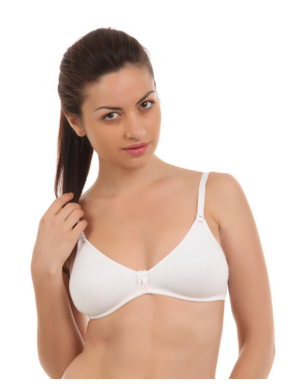

⬇------------------- изображение 28900.jpg -------------------⬇
Pink bikini briefs made of cotton/Lycra fabric, has an elastic waistband, low
rise styling and printed label on the inner  Fit Low rise  Wash care Machine
wash warm at 40 degrees with like colours Do not bleach, iron Tumble dry low
This pair of bikini briefs from enamor is crafted using premium cotton fabric
that provides quick dry breathability and no visible panty line. The cut allows
free leg movement, the fashion elastic with cushioning enhances a luxurious feel
and look, the no pinch elastic and printed label on the inside both provide
irritation-free comfort.  Model statistics Product is a size M on a model of
waist 26"


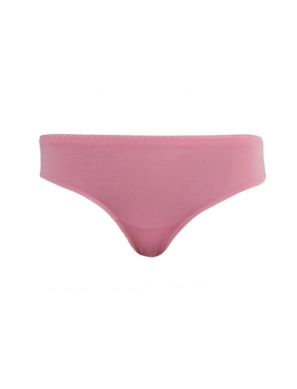

⬇------------------- изображение 17873.jpg -------------------⬇
Soft and stretchy vest made from 95% combed cotton and 5% elastane. This is an
indigo blue vest with high round neck and broad shoulders. The original two
horse Levi's logo features prominently on the back neck plus the signature red
tag is stitched to the bottom hem  Wash care Machine wash cold Do not bleach
Tumble dry low Cold iron as needed Do not dry clean  Classic vest shape and
prominent Levi's logo combine to create a ultra masculine vest to be worn under
any outfit.  The final product delivered might vary in colour and prints from
the display here.


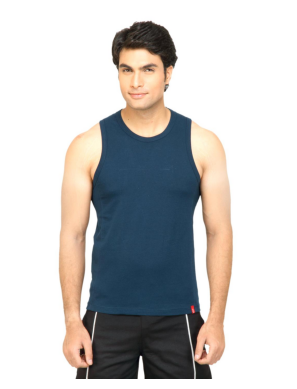

⬇------------------- изображение 50481.jpg -------------------⬇
Navy blue fashion mini briefs that have a blue, broad, elasticated waistband,
stitch detailing, printed branding on the front and slightly elasticated at the
legs for enhanced comfort  The final product delivered might vary in colour and
prints from the display here.


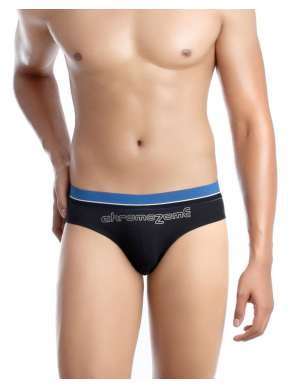

⬇------------------- изображение 20225.jpg -------------------⬇
Composition Red sweater made of a cotton/nylon blend, has a ribbed V-neck, long
sleeves with ribbed cuffs, a broad ribbed hem and brand badge appliquéd on the
left chest Fit Regular Wash care Hand wash separately using a mild detergent Do
not bleach, wring or tumble dry Flat dry in shade Mild iron; Do not iron on
decorations Top notch style and comfort, this sweater from wrangler is sure to
become a wardrobe favourite. The design and attention to detail is sure to earn
you fashion accolades, while the fabric will keep you fresh all day. Team this
with slim jeans, a shirt and casual shoes. Model statistics The product is a
size M on a model of height 5'8” and chest 33”


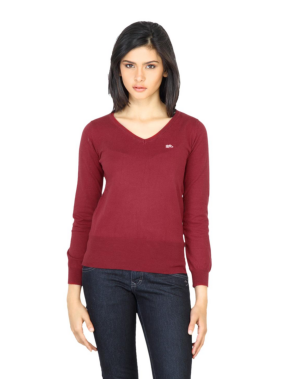

⬇------------------- изображение 6137.jpg -------------------⬇
Composition Eva,phylon,synthetic rubber shoe Care Rub surface with clean, damp
cloth to remove dust.Do not machine wash


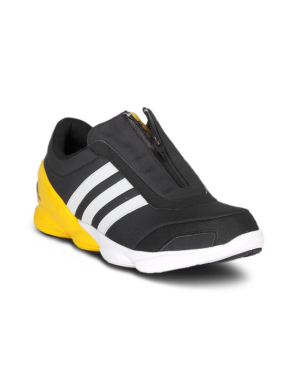

In [26]:
show_images (df_train.sample(10, random_state=RANDOM_STATE))

Описания данных 10 изображений являются корректными.

In [27]:
df_train.shape

(38791, 4)

In [28]:
df_val.shape

(4445, 2)

## Выводы по итогам EDA



- удалены образцы с пустыми или с незначищими описаниями (без букв)
- все изображения имеют разрешение  1080х1440
- всего изображения в тренировочном датасете осталось 38791, в валидационном - 4445
- описания выборочных 10 изображений являются корректными

## Подготовка датасета

Реализуем свой класс датасета, который будет подгружать картинки и соответствующие им текстовые описания.

In [29]:
class CLIPDataset(Dataset):
    def __init__(self, df, processor, tokenizer, base_path):
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.base_path, row['image'])
        description = row['description']

        try:
            image = Image.open(image_path).convert("RGB")
            image_inputs = self.processor(images=image, return_tensors="pt")
            
            text_inputs = self.tokenizer(
                description, 
                padding="max_length", 
                truncation=True, 
                max_length=self.tokenizer.model_max_length, 
                return_tensors="pt"
            )

            # Удаляем размерность батча, добавленную процессором/токенайзером
            return {
                'pixel_values': image_inputs['pixel_values'].squeeze(),
                'input_ids': text_inputs['input_ids'].squeeze(),
                'attention_mask': text_inputs['attention_mask'].squeeze()
            }
        
        except FileNotFoundError:
            print(f"Файл не найден: {image_path}. Пропускаем.")
            return None
        except Exception as e:
            print(f"Ошибка при загрузке {image_path}: {e}. Пропускаем.")
            return None

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

## Загрузка модели

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [31]:
model = CLIPModel.from_pretrained(MODEL_NAME).to(device)

In [32]:
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [33]:


train_dataset = CLIPDataset(df_train, processor, tokenizer, base_path=IMAGES_PATH)
val_dataset = CLIPDataset(df_val, processor, tokenizer, base_path=IMAGES_PATH)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn
)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [34]:
summary(model, device=device)

Layer (type:depth-idx)                                       Param #
CLIPModel                                                    1
├─CLIPTextTransformer: 1-1                                   --
│    └─CLIPTextEmbeddings: 2-1                               --
│    │    └─Embedding: 3-1                                   25,296,896
│    │    └─Embedding: 3-2                                   39,424
│    └─CLIPEncoder: 2-2                                      --
│    │    └─ModuleList: 3-3                                  37,828,608
│    └─LayerNorm: 2-3                                        1,024
├─CLIPVisionTransformer: 1-2                                 --
│    └─CLIPVisionEmbeddings: 2-4                             768
│    │    └─Conv2d: 3-4                                      2,359,296
│    │    └─Embedding: 3-5                                   38,400
│    └─LayerNorm: 2-5                                        1,536
│    └─CLIPEncoder: 2-6                                      -

Прогоним через модель несколько примеров из датасета и посмотрите, какие получаются CLIP-скоры:

In [35]:
def calculate_clip_score(image_features, text_features):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    logits_per_image = torch.matmul(image_features, text_features.t())
    return logits_per_image.diag().mean().item()*100

model.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    if sample_batch:
        sample_batch = {k: v.to(device) for k, v in sample_batch.items()}
        
        outputs = model(
            input_ids=sample_batch['input_ids'], 
            attention_mask=sample_batch['attention_mask'], 
            pixel_values=sample_batch['pixel_values'], 
            return_loss=True
        )
        
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
        initial_loss = outputs.loss.item()
        initial_score = calculate_clip_score(image_features, text_features)
        
        print(f"Начальная функция потерь (батч): {initial_loss:.4f}")
        print(f"Начальный CLIP Score (батч): {initial_score:.4f}")

Начальная функция потерь (батч): 0.8588
Начальный CLIP Score (батч): 30.2091


## Дообучение

In [36]:
def validate_epoch(model, val_loader, device):
    model.eval()
    total_clip_score = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Валидация"):
            if batch is None: continue
            
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask'], 
                pixel_values=batch['pixel_values'],
                return_loss=False # На валидации нам не нужна функция потерь
            )
            
            score = calculate_clip_score(outputs.image_embeds, outputs.text_embeds)
            total_clip_score += score
            num_batches += 1
            
    if num_batches == 0:
        return 0.0
        
    avg_clip_score = total_clip_score / num_batches
    return avg_clip_score

train_losses = []
train_scores = []
val_scores = []
best_val_score = -float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    epoch_score = 0.0
    num_batches = 0
    
    tqdm_loader = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{NUM_EPOCHS}")
    
    for batch in tqdm_loader:
        if batch is None: continue
        
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values'], 
            return_loss=True
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        score = calculate_clip_score(outputs.image_embeds, outputs.text_embeds)
        
        epoch_loss += loss.item()
        epoch_score += score
        num_batches += 1
        
        tqdm_loader.set_postfix(
            {
                'Train Loss': f'{epoch_loss/num_batches:.4f}', 
                'CLIP Score': f'{epoch_score/num_batches:.4f}'
            }
        )

    # --- Замер метрик эпохи ---
    avg_train_loss = epoch_loss / num_batches
    avg_train_score = epoch_score / num_batches
    train_losses.append(avg_train_loss)
    train_scores.append(avg_train_score)

    # --- Валидация ---
    avg_val_score = validate_epoch(model, val_loader, device)
    val_scores.append(avg_val_score)

    print(f"\n--- Эпоха {epoch+1} завершена ---")
    print(f"Средняя функция потерь (Train): {avg_train_loss:.4f}")
    print(f"Средний CLIP Score (Train): {avg_train_score:.4f}")
    print(f"Средний CLIP Score (Validation): {avg_val_score:.4f}")

    # --- Checkpoint ---
    if avg_val_score > best_val_score:
        best_val_score = avg_val_score
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_epoch_{epoch+1}_val_score_{avg_val_score:.4f}.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint сохранен: {checkpoint_path}")

Валидация:   1%|          | 1/139 [00:01<02:23,  1.04s/it]

Ошибка при загрузке archive/data/38197.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   5%|▌         | 7/139 [00:07<02:22,  1.08s/it]

Ошибка при загрузке archive/data/47657.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   7%|▋         | 10/139 [00:10<02:16,  1.06s/it]

Ошибка при загрузке archive/data/43119.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   9%|▉         | 13/139 [00:13<02:11,  1.04s/it]

Ошибка при загрузке archive/data/21539.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  12%|█▏        | 16/139 [00:17<02:09,  1.05s/it]

Ошибка при загрузке archive/data/44813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▎        | 19/139 [00:20<02:06,  1.06s/it]

Ошибка при загрузке archive/data/41784.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▍        | 20/139 [00:21<02:05,  1.06s/it]

Ошибка при загрузке archive/data/35207.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  24%|██▎       | 33/139 [00:34<01:50,  1.04s/it]

Ошибка при загрузке archive/data/39248.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  29%|██▉       | 41/139 [00:43<01:45,  1.07s/it]

Ошибка при загрузке archive/data/27781.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  33%|███▎      | 46/139 [00:48<01:39,  1.07s/it]

Ошибка при загрузке archive/data/9227.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 51/139 [00:53<01:32,  1.05s/it]

Ошибка при загрузке archive/data/9260.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/9251.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 52/139 [00:55<01:32,  1.06s/it]

Ошибка при загрузке archive/data/8960.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  45%|████▍     | 62/139 [01:05<01:21,  1.05s/it]

Ошибка при загрузке archive/data/38310.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  47%|████▋     | 66/139 [01:09<01:16,  1.05s/it]

Ошибка при загрузке archive/data/9261.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  50%|████▉     | 69/139 [01:12<01:12,  1.04s/it]

Ошибка при загрузке archive/data/35213.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/46440.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  55%|█████▌    | 77/139 [01:21<01:05,  1.06s/it]

Ошибка при загрузке archive/data/27764.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  56%|█████▌    | 78/139 [01:22<01:03,  1.04s/it]

Ошибка при загрузке archive/data/46813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  70%|██████▉   | 97/139 [01:42<00:44,  1.05s/it]

Ошибка при загрузке archive/data/27762.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  78%|███████▊  | 108/139 [01:53<00:32,  1.05s/it]

Ошибка при загрузке archive/data/8861.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  81%|████████▏ | 113/139 [01:59<00:27,  1.06s/it]

Ошибка при загрузке archive/data/31857.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  83%|████████▎ | 115/139 [02:01<00:25,  1.06s/it]

Ошибка при загрузке archive/data/39274.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  87%|████████▋ | 121/139 [02:07<00:18,  1.05s/it]

Ошибка при загрузке archive/data/31865.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38165.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38182.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  95%|█████████▍| 132/139 [02:18<00:07,  1.04s/it]

Ошибка при загрузке archive/data/9061.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  97%|█████████▋| 135/139 [02:21<00:04,  1.06s/it]

Ошибка при загрузке archive/data/45676.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация: 100%|██████████| 139/139 [02:26<00:00,  1.05s/it]



--- Эпоха 1 завершена ---
Средняя функция потерь (Train): 0.5324
Средний CLIP Score (Train): 27.9718
Средний CLIP Score (Validation): 29.8289
Checkpoint сохранен: clip_checkpoints/best_model_epoch_1_val_score_29.8289.pt


Валидация:   1%|          | 1/139 [00:00<01:49,  1.26it/s]

Ошибка при загрузке archive/data/38197.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   5%|▌         | 7/139 [00:05<01:44,  1.26it/s]

Ошибка при загрузке archive/data/47657.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   7%|▋         | 10/139 [00:08<01:44,  1.24it/s]

Ошибка при загрузке archive/data/43119.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   9%|▉         | 13/139 [00:10<01:40,  1.26it/s]

Ошибка при загрузке archive/data/21539.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  12%|█▏        | 16/139 [00:12<01:39,  1.23it/s]

Ошибка при загрузке archive/data/44813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▎        | 19/139 [00:15<01:36,  1.24it/s]

Ошибка при загрузке archive/data/41784.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▍        | 20/139 [00:16<01:35,  1.25it/s]

Ошибка при загрузке archive/data/35207.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  24%|██▍       | 34/139 [00:27<01:24,  1.24it/s]

Ошибка при загрузке archive/data/39248.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  29%|██▉       | 41/139 [00:33<01:20,  1.22it/s]

Ошибка при загрузке archive/data/27781.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  33%|███▎      | 46/139 [00:37<01:15,  1.22it/s]

Ошибка при загрузке archive/data/9227.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 51/139 [00:41<01:11,  1.24it/s]

Ошибка при загрузке archive/data/9260.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 52/139 [00:41<01:09,  1.24it/s]

Ошибка при загрузке archive/data/9251.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/8960.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  45%|████▍     | 62/139 [00:49<01:01,  1.25it/s]

Ошибка при загрузке archive/data/38310.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  47%|████▋     | 66/139 [00:53<00:59,  1.23it/s]

Ошибка при загрузке archive/data/9261.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  50%|████▉     | 69/139 [00:55<00:56,  1.24it/s]

Ошибка при загрузке archive/data/35213.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/46440.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  55%|█████▌    | 77/139 [01:02<00:49,  1.24it/s]

Ошибка при загрузке archive/data/27764.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  56%|█████▌    | 78/139 [01:02<00:49,  1.24it/s]

Ошибка при загрузке archive/data/46813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  71%|███████   | 98/139 [01:19<00:33,  1.23it/s]

Ошибка при загрузке archive/data/27762.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  78%|███████▊  | 108/139 [01:27<00:25,  1.23it/s]

Ошибка при загрузке archive/data/8861.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  81%|████████▏ | 113/139 [01:31<00:20,  1.24it/s]

Ошибка при загрузке archive/data/31857.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  83%|████████▎ | 115/139 [01:32<00:19,  1.24it/s]

Ошибка при загрузке archive/data/39274.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  87%|████████▋ | 121/139 [01:37<00:14,  1.24it/s]

Ошибка при загрузке archive/data/31865.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38165.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38182.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  95%|█████████▍| 132/139 [01:46<00:05,  1.24it/s]

Ошибка при загрузке archive/data/9061.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  97%|█████████▋| 135/139 [01:48<00:03,  1.24it/s]

Ошибка при загрузке archive/data/45676.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация: 100%|██████████| 139/139 [01:52<00:00,  1.24it/s]



--- Эпоха 2 завершена ---
Средняя функция потерь (Train): 0.3496
Средний CLIP Score (Train): 31.6287
Средний CLIP Score (Validation): 32.6291
Checkpoint сохранен: clip_checkpoints/best_model_epoch_2_val_score_32.6291.pt


Валидация:   1%|          | 1/139 [00:00<01:49,  1.26it/s]

Ошибка при загрузке archive/data/38197.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   5%|▌         | 7/139 [00:05<01:45,  1.25it/s]

Ошибка при загрузке archive/data/47657.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   7%|▋         | 10/139 [00:08<01:46,  1.21it/s]

Ошибка при загрузке archive/data/43119.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   9%|▉         | 13/139 [00:10<01:41,  1.24it/s]

Ошибка при загрузке archive/data/21539.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  12%|█▏        | 16/139 [00:12<01:39,  1.24it/s]

Ошибка при загрузке archive/data/44813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▎        | 19/139 [00:15<01:35,  1.25it/s]

Ошибка при загрузке archive/data/41784.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▍        | 20/139 [00:16<01:34,  1.25it/s]

Ошибка при загрузке archive/data/35207.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  24%|██▍       | 34/139 [00:27<01:25,  1.23it/s]

Ошибка при загрузке archive/data/39248.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  29%|██▉       | 41/139 [00:33<01:21,  1.20it/s]

Ошибка при загрузке archive/data/27781.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  33%|███▎      | 46/139 [00:37<01:16,  1.21it/s]

Ошибка при загрузке archive/data/9227.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 51/139 [00:41<01:11,  1.24it/s]

Ошибка при загрузке archive/data/9260.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/9251.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 52/139 [00:42<01:12,  1.21it/s]

Ошибка при загрузке archive/data/8960.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  45%|████▍     | 62/139 [00:50<01:02,  1.24it/s]

Ошибка при загрузке archive/data/38310.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  47%|████▋     | 66/139 [00:53<00:59,  1.24it/s]

Ошибка при загрузке archive/data/9261.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  50%|████▉     | 69/139 [00:56<00:56,  1.24it/s]

Ошибка при загрузке archive/data/35213.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/46440.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  55%|█████▌    | 77/139 [01:02<00:50,  1.23it/s]

Ошибка при загрузке archive/data/27764.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  56%|█████▌    | 78/139 [01:03<00:49,  1.22it/s]

Ошибка при загрузке archive/data/46813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  71%|███████   | 98/139 [01:19<00:33,  1.23it/s]

Ошибка при загрузке archive/data/27762.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  78%|███████▊  | 108/139 [01:27<00:25,  1.22it/s]

Ошибка при загрузке archive/data/8861.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  81%|████████▏ | 113/139 [01:31<00:20,  1.24it/s]

Ошибка при загрузке archive/data/31857.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  83%|████████▎ | 115/139 [01:33<00:19,  1.23it/s]

Ошибка при загрузке archive/data/39274.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  87%|████████▋ | 121/139 [01:37<00:14,  1.24it/s]

Ошибка при загрузке archive/data/31865.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38165.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38182.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  95%|█████████▍| 132/139 [01:46<00:05,  1.26it/s]

Ошибка при загрузке archive/data/9061.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  97%|█████████▋| 135/139 [01:49<00:03,  1.23it/s]

Ошибка при загрузке archive/data/45676.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация: 100%|██████████| 139/139 [01:52<00:00,  1.24it/s]



--- Эпоха 3 завершена ---
Средняя функция потерь (Train): 0.2994
Средний CLIP Score (Train): 33.8916
Средний CLIP Score (Validation): 34.5589
Checkpoint сохранен: clip_checkpoints/best_model_epoch_3_val_score_34.5589.pt


Валидация:   1%|          | 1/139 [00:00<01:52,  1.22it/s]

Ошибка при загрузке archive/data/38197.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   5%|▌         | 7/139 [00:05<01:50,  1.20it/s]

Ошибка при загрузке archive/data/47657.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   7%|▋         | 10/139 [00:08<01:45,  1.23it/s]

Ошибка при загрузке archive/data/43119.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:   9%|▉         | 13/139 [00:10<01:43,  1.22it/s]

Ошибка при загрузке archive/data/21539.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  12%|█▏        | 16/139 [00:13<01:40,  1.23it/s]

Ошибка при загрузке archive/data/44813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▎        | 19/139 [00:15<01:38,  1.22it/s]

Ошибка при загрузке archive/data/41784.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  14%|█▍        | 20/139 [00:16<01:37,  1.23it/s]

Ошибка при загрузке archive/data/35207.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  24%|██▍       | 34/139 [00:27<01:23,  1.25it/s]

Ошибка при загрузке archive/data/39248.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  29%|██▉       | 41/139 [00:33<01:18,  1.24it/s]

Ошибка при загрузке archive/data/27781.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  33%|███▎      | 46/139 [00:37<01:14,  1.24it/s]

Ошибка при загрузке archive/data/9227.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 51/139 [00:41<01:12,  1.22it/s]

Ошибка при загрузке archive/data/9260.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  37%|███▋      | 52/139 [00:42<01:10,  1.23it/s]

Ошибка при загрузке archive/data/9251.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/8960.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  45%|████▍     | 62/139 [00:50<01:01,  1.24it/s]

Ошибка при загрузке archive/data/38310.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  47%|████▋     | 66/139 [00:53<00:59,  1.23it/s]

Ошибка при загрузке archive/data/9261.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  50%|████▉     | 69/139 [00:55<00:57,  1.23it/s]

Ошибка при загрузке archive/data/35213.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/46440.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  55%|█████▌    | 77/139 [01:02<00:50,  1.22it/s]

Ошибка при загрузке archive/data/27764.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  56%|█████▌    | 78/139 [01:03<00:49,  1.23it/s]

Ошибка при загрузке archive/data/46813.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  71%|███████   | 98/139 [01:19<00:33,  1.22it/s]

Ошибка при загрузке archive/data/27762.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  78%|███████▊  | 108/139 [01:27<00:25,  1.22it/s]

Ошибка при загрузке archive/data/8861.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  81%|████████▏ | 113/139 [01:31<00:21,  1.23it/s]

Ошибка при загрузке archive/data/31857.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  83%|████████▎ | 115/139 [01:33<00:19,  1.24it/s]

Ошибка при загрузке archive/data/39274.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  87%|████████▋ | 121/139 [01:38<00:14,  1.22it/s]

Ошибка при загрузке archive/data/31865.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38165.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.
Ошибка при загрузке archive/data/38182.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  95%|█████████▍| 132/139 [01:47<00:05,  1.24it/s]

Ошибка при загрузке archive/data/9061.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация:  97%|█████████▋| 135/139 [01:49<00:03,  1.22it/s]

Ошибка при загрузке archive/data/45676.jpg: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).. Пропускаем.


Валидация: 100%|██████████| 139/139 [01:53<00:00,  1.23it/s]



--- Эпоха 4 завершена ---
Средняя функция потерь (Train): 0.2613
Средний CLIP Score (Train): 35.4835
Средний CLIP Score (Validation): 35.9347
Checkpoint сохранен: clip_checkpoints/best_model_epoch_4_val_score_35.9347.pt


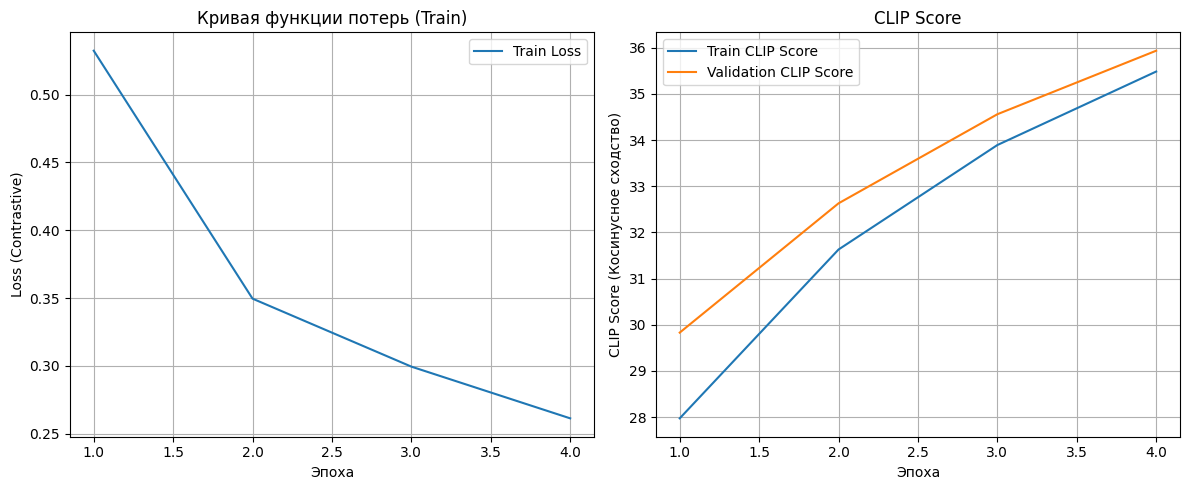

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.title('Кривая функции потерь (Train)')
plt.xlabel('Эпоха')
plt.ylabel('Loss (Contrastive)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_scores, label='Train CLIP Score')
plt.plot(range(1, NUM_EPOCHS + 1), val_scores, label='Validation CLIP Score')
plt.title('CLIP Score')
plt.xlabel('Эпоха')
plt.ylabel('CLIP Score (Косинусное сходство)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Освободим память, т. к. в задании далее треубется загрузить модель из чекпоинта:

In [38]:
if not JUST_DEBUG_ON_CPU:
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    torch.cuda.ipc_collect()
    print(torch.cuda.memory_summary())
del model
del processor
del tokenizer

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2369 MiB |   4189 MiB |  50371 GiB |  50368 GiB |
|       from large pool |   2167 MiB |   4025 MiB |  49743 GiB |  49741 GiB |
|       from small pool |    201 MiB |    251 MiB |    627 GiB |    627 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2369 MiB |   4189 MiB |  50371 GiB |  50368 GiB |
|       from large pool |   2167 MiB |   4025 MiB |  49743 GiB |

# Этап 2. Реализация системы поиска товаров

## Подготовка модели и данных

Загрузим чекпоинт дообученной модели:

In [39]:
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pt')]

In [40]:
last_checkpoint = sorted(checkpoint_files, reverse=True)[0] 
BEST_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, last_checkpoint)
BEST_CHECKPOINT_PATH

'clip_checkpoints/best_model_epoch_4_val_score_35.9347.pt'

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
model_search = CLIPModel.from_pretrained(MODEL_NAME).to(device)
model_search.load_state_dict(torch.load(BEST_CHECKPOINT_PATH, map_location=device))
model_search.eval()
processor_search = CLIPProcessor.from_pretrained(MODEL_NAME)
tokenizer_search = CLIPTokenizer.from_pretrained(MODEL_NAME)

Все пропуски description заполним пустой строкой:

In [43]:
df['description'] = df['description'].fillna('')

 Сохраним все векторные представления изображений:

In [44]:
all_dataset = CLIPDataset(df, processor_search, tokenizer_search, base_path=IMAGES_PATH)
all_loader = DataLoader(
    all_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn
)
all_image_embeddings = []

In [45]:
with torch.no_grad():
    for batch in tqdm(all_loader, desc="Кодирование изображений"):
        if batch is None:
            continue
            
        pixel_values = batch['pixel_values'].to(device)
        image_embeds = model_search.get_image_features(pixel_values)
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        all_image_embeddings.append(image_embeds.cpu())

all_image_embeddings_tensor = torch.cat(all_image_embeddings)
print(f"Общее количество закодированных векторов: {all_image_embeddings_tensor.shape[0]}")
print(f"Размерность векторов: {all_image_embeddings_tensor.shape[1]}")

# Сохраняем векторные представления и исходный DataFrame для поиска
df_indexed = df.copy()
df_indexed['embeddings'] = all_image_embeddings_tensor.tolist()

Кодирование изображений: 100%|██████████| 1389/1389 [18:07<00:00,  1.28it/s]


Общее количество закодированных векторов: 44441
Размерность векторов: 512


In [46]:
pd.options.display.max_colwidth = 500

In [47]:
df_indexed.head(3)

,image,description,embeddings
0,3238.jpg,"Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only","[-0.026110362261533737, -0.018153516575694084, 0.023342963308095932, -0.0034603956155478954, 0.011205287650227547, 0.017147893086075783, 0.006496445741504431, 0.011464466340839863, 0.0015200688503682613, -0.026791352778673172, 0.0022963236551731825, -0.019744019955396652, -0.030235527083277702, -0.014471838250756264, 0.01605459675192833, 0.03258051723241806, 0.07264744490385056, -0.02026357501745224, 0.024458754807710648, 0.0019253049977123737, 0.0006807885365560651, 0.03895793482661247, 0.0..."
1,43044.jpg,"Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water...","[-0.009005239233374596, -0.014993292279541492, -0.005458575673401356, 0.0007037462783046067, 0.010932305827736855, 0.0016429283423349261, 0.000435147259850055, 0.0010169391753152013, 0.031979549676179886, 0.0046329256147146225, 0.022077683359384537, 0.0010484925005584955, -0.015057768672704697, 0.00648335600271821, -0.009872340597212315, 0.026687005534768105, 0.07258238643407822, -0.0041105174459517, -0.0025091920979321003, 0.012504976242780685, -0.0743810310959816, 0.010588949546217918, 0.0..."
2,54018.jpg,"Teal handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back","[0.0141377504914999, 0.010365290567278862, -0.009966994635760784, 0.004235553089529276, 0.01058574765920639, 0.03161950409412384, -0.006889550015330315, 0.0029995860531926155, 0.010112526826560497, 0.005386564880609512, 0.004897349514067173, 0.004876662511378527, 0.004401287995278835, 0.009825320914387703, 0.011890796944499016, 0.020113496109843254, -0.010047227144241333, 0.0025735213421285152, -0.039952002465724945, 0.011991865932941437, -0.016287636011838913, -0.022535325959324837, 0.05640..."


## Функция поиска товаров

In [48]:
def show_results(results_df, query):
    pd.options.display.max_colwidth = 1000
    
    print("-" * 100)
    print(f"Текстовый запрос: '{query}'")
    print(f"Найдено {len(results_df)} наиболее релевантных товаров.")
    
    for _, row in results_df.iterrows():
        image_path = os.path.join(IMAGES_PATH, row['image'])
        
        try:
            image = Image.open(image_path)
            
            print(f"⬇------------------- Товар: {row['image']} | CLIP Score: {row['Similarity Score']:.4f} -------------------⬇")
            
            # Используем textwrap для переноса описания
            wrapped_description = textwrap.fill(row['description'], width=80)
            print(wrapped_description)
            
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        
        except FileNotFoundError:
            print(f"Ошибка: Файл не найден по пути {image_path}. Пропускаем отображение.")
        except Exception as e:
            print(f"Произошла ошибка при обработке изображения: {e}. Пропускаем отображение.")

In [49]:
def search_products(
    model: CLIPModel, 
    tokenizer: CLIPTokenizer,
    df_indexed: pd.DataFrame, 
    query: str, 
    k: int = 5, 
    device: str = 'cpu',
    ):

    with torch.no_grad():
        text_inputs = tokenizer(
            query, 
            padding="max_length", 
            truncation=True, 
            max_length=tokenizer.model_max_length, 
            return_tensors="pt"
        ).to(device)
        
        text_embeds = model.get_text_features(
            input_ids=text_inputs['input_ids'], 
            attention_mask=text_inputs['attention_mask']
        )
        
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds.cpu()

    image_embeddings = torch.tensor(df_indexed['embeddings'].tolist())
    
    similarity_scores = torch.matmul(text_embeds, image_embeddings.T).squeeze(0)

    top_k_values, top_k_indices = torch.topk(similarity_scores, k)

    results_df = df_indexed.iloc[top_k_indices.tolist()].copy()
    results_df['Similarity Score'] = top_k_values.tolist()
    
    show_results (results_df.drop(columns=['embeddings']).reset_index(drop=True), query)

## Тестирование

----------------------------------------------------------------------------------------------------
Текстовый запрос: 'red skirt'
Найдено 5 наиболее релевантных товаров.
⬇------------------- Товар: 13304.jpg | CLIP Score: 0.3901 -------------------⬇
Composition Red skort made of 100% cotton, has an elasticated waistband, two
patch pockets on the back, a zipper fly, and brand name embroidered above the
left hem in silver Fitting Regular Wash care Machine wash separately in cold
water using a mild detergent Do not bleach or soak Line dry inside out in shade
Warm iron only Do not iron directly on print/embroidery The cute statement
simply zooms high when you dress your little girl in this skort from gini and
jony. The shorts and box pleats offer her absolute comfort to move around in
ease, while the fabric keeps her fresh and comfortable all day. Team this with a
T-shirt or girly tops, and sandals, and let your little one play in much
comfort.


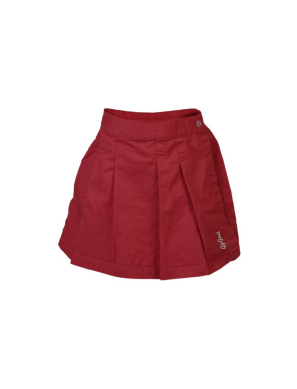

⬇------------------- Товар: 13305.jpg | CLIP Score: 0.3901 -------------------⬇
Composition Red skirt made of 100% cotton, has an elasticated waistband, two
patch pockets on the back, a zipper fly, and brand name embroidered above the
left hem in silver Fitting Regular Wash care Machine wash separately in cold
water using a mild detergent Do not bleach or soak Line dry inside out in shade
Warm iron only Do not iron directly on print/embroidery The cute statement
simply zooms high when you dress your little girl in this skort from gini and
jony. The shorts and box pleats offer her absolute comfort to move around in
ease, while the fabric keeps her fresh and comfortable all day. Team this with a
T-shirt or girly tops, and sandals, and let your little one play in much
comfort.


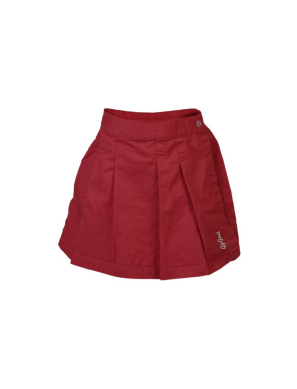

⬇------------------- Товар: 44922.jpg | CLIP Score: 0.3899 -------------------⬇
Style Note Designed for the sporty soul, this pair of shorts from puma is
crafted from soft and absorbent polyester fabric that offers exemplary comfort.
The comfortable elasticated waistband sits snug, while you can further customise
the Fit with the drawstring. Slip into these shorts when blazing the trail on a
healthy run, or on casual day at home, and revel in heavenly comfort.  Product
Details Red shorts with a mesh like inner, an elasticated waistband and
drawstrings on the inside, side pockets, brand tab appliqued below the right
pocket and printed branding on the left thigh  Material and Care Shell: 100%
polyester Lining: 100% polyester Gentle machine wash in lukewarm water with like
colours Do not bleach or dry clean Tumble dry low Warm iron  Size and Fit
Regular fit The model (height 6' and waist 32”) is wearing a size M


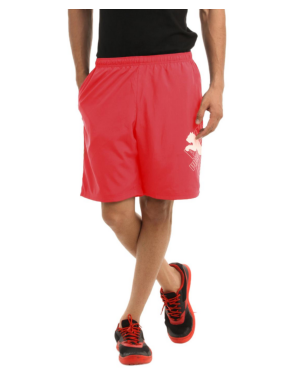

⬇------------------- Товар: 5005.jpg | CLIP Score: 0.3893 -------------------⬇
Composition Coral shorts made of 100% cotton, with elasticated waist, two patch
pockets on the back with buttoned flaps, pleated foldover flap on the front and
embroidered brand name on the left side of flap Fitting Regular Waist - 22-24
inches  Wash care   Machine wash  Cold water  Wash with like colours  Wash/dry
inside out  Use mild detergents  Do not tumble dry  Use warm iron  Do not iron
on decor  Remove all detachable   Get ready to indulge your little girl in the
spirit of summer with these coral skorts from gini and jony. Team this with
white tees and comfy crocs footwear for a happy, casual outing with her small
buddies, while the soft fabric stays soft on her skin and keeps her fresh and
comfortable all day.


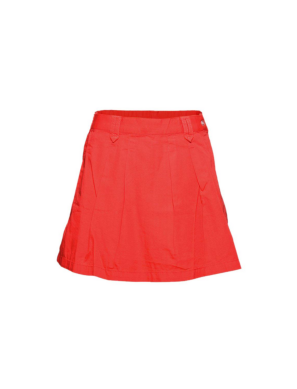

⬇------------------- Товар: 27418.jpg | CLIP Score: 0.3876 -------------------⬇
Red capris, elasticated waist, branding and piping at the sides, pocket at the
back


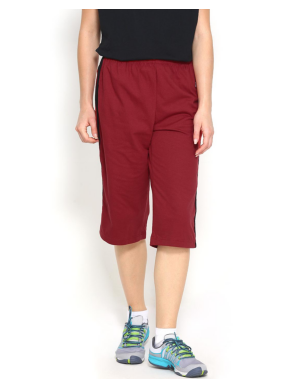

In [50]:
search_products(
    model=model_search, 
    tokenizer=tokenizer_search,
    df_indexed=df_indexed, 
    query="red skirt", 
    k=5, 
    device=device,
)

----------------------------------------------------------------------------------------------------
Текстовый запрос: 'blue sunglasses'
Найдено 5 наиболее релевантных товаров.
⬇------------------- Товар: 40164.jpg | CLIP Score: 0.3788 -------------------⬇
Style Note High on style, this pair of distortion free sunglasses from fastrack
comes in a styled frame. An eclectic mixture of fashion and substance, its shape
provides that perfect Fit over the root of your nose. The glasses come with a
sturdy case and a micro fibre cloth to keep the accessory clean.   Product
Details Lens colour: Blue Lens type: Tinted glass lens with 100% UV protection
Frame colour: Black Frame type: Plastic full frame Flexible hinges for
durability Fixed nose holder with a thick nose bridge which is part of the frame
to hold the glasses in place, ensuring there is no friction with the skin The
glasses come with a sturdy case and a micro fibre cloth to keep the accessory
clean  Warranty: 1 Year   Material and Car

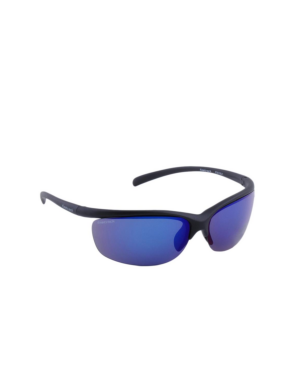

⬇------------------- Товар: 39995.jpg | CLIP Score: 0.3769 -------------------⬇
Style Note park avenue provides the stylish man-about-town with all the
essentials he needs to look his best. Wear these park avenue sunglasses to look
stylish while out and about in the sunshine. Product Details Lens colour: Blue
Lens style: Tinted Frame colour: Black and blue Frame type: Metal frame with
acrylic arms with blue rubber inner provide a comfortable Fit and branding on
the arms Flexible hinges for fit The glasses come in a leather-look case with
branding on the front and a zip fastening, cloth included to clean the lenses
Material and Care Metal Remove dust and grime by gently wiping the lens with the
cloth provided Rmove oil or tough stains with the help of a lens cleaner and do
not use your fingers Do not place your glasses on uneven surfaces or heated
areas (like a dashboard) Size Lens width: 65 mm


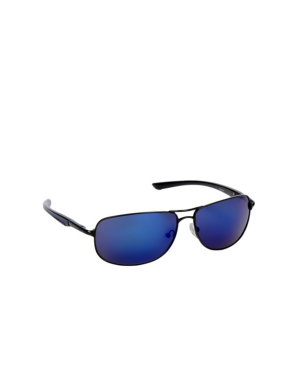

⬇------------------- Товар: 30285.jpg | CLIP Score: 0.3764 -------------------⬇
sunglasses that make you look like an icon: that's the thrill speedo offers!
Whether playing sport, or hitting the beach, accessorise your active lifestyle
with a pair of ultra stylish


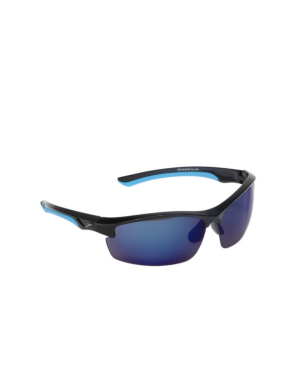

⬇------------------- Товар: 16894.jpg | CLIP Score: 0.3746 -------------------⬇
High on style, this pair of sunglasses from police comes in a styled frame. An
eclectic mixture of fashion and substance, its shape provides that perfect Fit
over the root of your nose. The glasses come with a sturdy case and a puck which
doubles as a storage and wiping cloth for the accessory.  Tinted lens for UV
protection in bright daylight Plastic frame in an aerodynamic design Square lens
for absolute style and protection from elements Fixed nose holder to hold the
glasses in place, ensuring there is no friction with the skin   Care Remove dust
and grime by gently wiping the lens with a soft cloth Remove oil or tough stains
using a non-abrasive common detergent with lukewarm water Wear and remove the
glasses using both hands Always store the glasses in the case provided Do not
place glasses on uneven surface or heated areas like the dashboard of a car


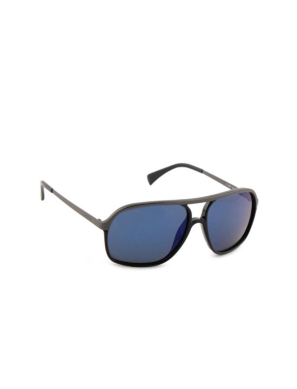

⬇------------------- Товар: 40181.jpg | CLIP Score: 0.3744 -------------------⬇
Style Note High on style, this pair of distortion free sunglasses from fastrack
comes in a styled frame. An eclectic mixture of fashion and substance, its shape
provides that perfect Fit over the root of your nose. The glasses come with a
sturdy case and a micro fibre cloth to keep the accessory clean.   Product
Details Lens colour: Greenish blue Lens type: Tinted glass lens with 100% UV
protection Frame colour: Grey Frame type: Plastic full frame Flexible hinges for
durability Fixed nose holder with a thick nose bridge which is part of the frame
to hold the glasses in place, ensuring there is no friction with the skin The
glasses come with a sturdy case and a micro fibre cloth to keep the accessory
clean  Warranty: 1 Year   Material and Care Plastic Remove dust and grime by
gently wiping the lens with the cloth provided Remove oil or tough stains with
the help of a lens cleaner Do not use your fingers on s

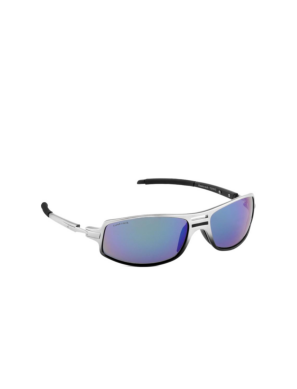

In [51]:
search_products(
    model=model_search, 
    tokenizer=tokenizer_search,
    df_indexed=df_indexed, 
    query="blue sunglasses", 
    k=5, 
    device=device,
)

----------------------------------------------------------------------------------------------------
Текстовый запрос: 'mickey mouse'
Найдено 5 наиболее релевантных товаров.
⬇------------------- Товар: 47101.jpg | CLIP Score: 0.3923 -------------------⬇
  Style Note  Gear up your little hero for his everyday adventures with this
pair of floaters from Spider-Man. Its cushioned footbed and grooved outsole let
him stay on his feet all day long. Pair it with a cotton tee and shorts for an
outing in the park.  Product Details  Yellow printed synthetic leather straps on
the forefoot, midfoot and backfoot  Velcro closure on the midfoot strap with
branding  Ergonomically curved footbed with grooves for grip  Rubber outsole
with grooves for absolute grip and traction  Material and Care  Synthetic,
rubber  Wipe with a clean damp cloth to remove dust  Do not store under sunlight
Style Note Gear up your little hero for his everyday adventures with this pair
of floaters from Spider-Man. Its cushion

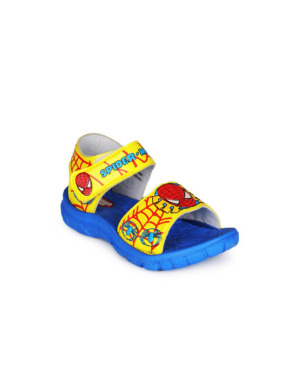

⬇------------------- Товар: 10772.jpg | CLIP Score: 0.3893 -------------------⬇
Cuddle up your little man in these fun and sunny slip-ons from disney. With a
comfortable velcro strap enclosure, this shoe offers absolute comfort and style.
Upper Canvas upper with fibre motifs of disney logo Toe guard in rubber to
protect the foot from shock Extra piping around the collar to avoid shoe bites
Midsole Soft, foamy footbed Lightweight phylon midsole Outsole Multi textured
rubber outsole for great grip Shoe care Make a paste using 1 tbsp of baking
soda, 1 tbsp white vinegar and 1 tbsp hot water Rub this paste onto the canvas
and the sole using a brush Wash off with lukewarm water


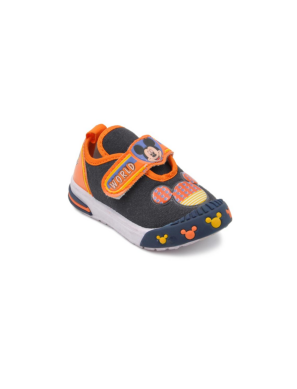

⬇------------------- Товар: 20864.jpg | CLIP Score: 0.3889 -------------------⬇
Let your little child play with much glee in these slip-resistant floaters from
disney. You are sure to feel contented with your choice when you see that your
kid is playing on the clouds in these soft footbeds and padded straps. Upper
Durable and soft upper with straps over the forefoot and the ankle Extra padding
over the ankle and forefoot straps Straps attached to velcro fasteners Pull loop
attached to the ankle strap for ease of wear Soft, foamy footbed with Pluto
embedded on the footbed for all-day massage feel Outsole Multi-directional lugs
throughout the TPR outsole with an impact guidance line for better energy return
shoe care Wipe surface with soft, clean, damp cloth Do not wash or store shoes
in direct sunlight


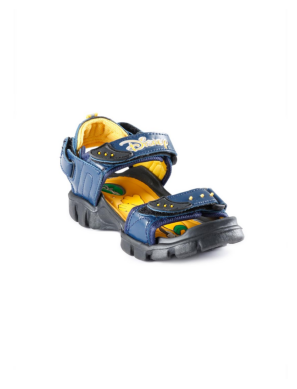

⬇------------------- Товар: 15866.jpg | CLIP Score: 0.3873 -------------------⬇
A great shoe for casual days out, the Scooby Doo Sill Shoe from Warner Brothers
makes for a perfect addition to your little one's wardrobe. With a fun upper,
cushioned footbed and grippy outsole, you are assured that your little one has
the feet firm on the ground.   Upper  Synthetic leather upper with a meshed
forefoot Velcro straps on the midfoot for a custom Fit Padded tongue, collar and
footbed with fabric lining for sweat-free comfort Scooby Doo cartoon embossed on
the lateral midfoot   Midsole  EVA midsole for lightweight comfort and impact
protection   Outsole  Durable rubber outsole with oval lugs and grooves for
absolute grip and traction   Care  Wipe surface with a clean, dry cloth to
remove dust Do not store in direct sunlight


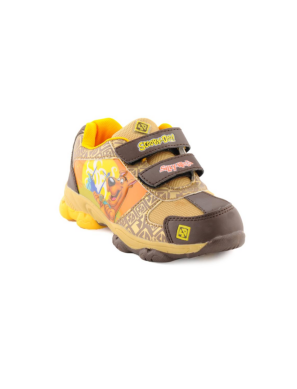

⬇------------------- Товар: 13375.jpg | CLIP Score: 0.3851 -------------------⬇
Gift your child that absolute comfort with the timberland Riverquest Closed Toe
sandal. The soft leather upper and padded fabric inner lining will find your
little one playing in absolute comfort.   Upper Leather upper straps with velcro
closures on the forefoot, midfoot and back heel for an ultimate snug, customised
Fit Padded fabric inner lining for all-day, sweat-free comfort Paded foam
footbed for all-day comfort   Outsole Durable rubber outsole with grooves on the
forefoot, lugs on the sides of the forefoot and heel, and brand name as a lug
through the mid length for absolute grip and traction  Floater care Wipe dust
with a dry, clean cloth Do not wash or store in direct sunlight


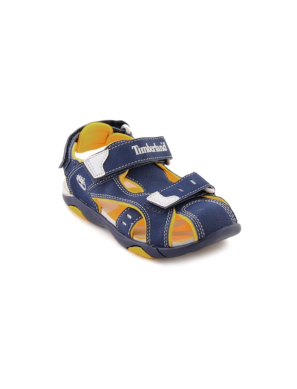

In [52]:
search_products(
    model=model_search, 
    tokenizer=tokenizer_search,
    df_indexed=df_indexed, 
    query="mickey mouse", 
    k=5, 
    device=device,
)

# Выводы



- В соответствии с поставленной задачей(см. первый раздел)
    - была проведена подготовка данных и их разведочный анализ, в результате которых:
        - удалены образцы с пустыми или с незначищими описаниями (без букв)
        - описания выборочных 10 изображений являются корректными
    - была дообучена модель openai/clip-vit-base-patch32, предсказывающая семантическое сходство между изображением и текстовым описанием в виде CLIP-Score [-1, 1], где 1 - это полноей совпадение.
        - В процессе 4 эпох обучения была актматически выбрана наиболее оптимальная модель наилучшим  CLIP-Score:
            - изначальное качество предсказания на первом батче = 30.34
            - качество предсказания после дообучения (Validation): 35.9347
            - это удовлетворяет заданный критерий качества: >= 30
            - судя по кривым обучения - не исчерпан потенциал для дальнейшего обучения модели